In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import wandb

import torch
import torch.nn.functional as F
from torch.nn import ReLU, Linear, Sequential, ModuleList
from torch_geometric.nn import HypergraphConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

import functions as f

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
os.environ['WANDB_NOTEBOOK_NAME']="HGNN_Conv.ipynb"

In [3]:
# Convolutional Hypergraph Networks
class HGConv(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, nbr_classes):
        super(HGConv, self).__init__()
        self.nbr_classes = nbr_classes
        self.convs = ModuleList()
        self.convs.append(f.HypergraphConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(f.HypergraphConv(hidden_channels, hidden_channels))
        # self.double_mlp = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.mlp = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
                # xs.append(x)
        x = global_mean_pool(x, batch)
        # x = torch.cat(xs, dim=1)
        # x = self.double_mlp(x)
        x = self.mlp(x)
        return x

In [4]:
# Testing the class Raw_to_Hypergraph with one example and saving it
threshold = 0.4
age = False
sex = False
method = 'fourier_cluster'
if method == 'coskewness':
    weight = True
else:
    weight = False

hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'

root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
dataset = f.Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

In [5]:
# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes = f.create_train_test_valid(dataset)

Number of training graphs: 136
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# Training the model
def train(model, optimizer, criterion, w_decay, threshold, train_loader, valid_loader, parameters, test_loader=False, testing=False, n_epochs=100):
    test_loader = test_loader
    testing = testing
    n_epochs = n_epochs

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []
    max_valid_accuracy = 0

    # start a new wandb run to track this script
    run = wandb.init(
        # set the wandb project where this run will be logged
        project = "Alzheimers_GNN",
        # track hyperparameters and run metadata
        config = {
        "architecture": "HGConv",
        "weights": weight,
        "weight_decay": w_decay,
        "threshold": threshold,
        "matrix profiling": True,
        "learning_rate": parameters[0],
        "hidden_channels": parameters[1],
        "num_layers": parameters[2],
        "dropout": parameters[3],
        "epochs": n_epochs},)

    for epoch in range(n_epochs):
        if testing:
            train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_losses, test_accuracies = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_losses, test_accuracies)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')
            print(f'Max Validation Accuracy: {max_valid_accuracy:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Max Valid Accuracy": max_valid_accuracy, "Test Loss": test_losses[-1], "Test Accuracy": test_accuracies[-1]})
        else:
            train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')
            print(f'Max Validation Accuracy: {max_valid_accuracy:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Max Valid Accuracy": max_valid_accuracy})

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    if testing:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    if testing:
        plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save the plot
    lr = parameters[0]
    hidden_channels = parameters[1]
    num_layers = parameters[2]
    dropout = parameters[3]
    filename = f'HGConv_Models_MP/threshold_{threshold}/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}_wdecay{w_decay}_w{weight}.png'
    plt.savefig(filename)
    plt.show()

    wandb.finish()

    if testing:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_losses, test_accuracies
    else:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy

Number of training graphs: 136
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4
HGConv(
  (convs): ModuleList(
    (0): HypergraphConv(456, 32)
    (1-2): 2 x HypergraphConv(32, 32)
  )
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Max Valid Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▆▆▇▃▄▆▃▆▃▆▃▆▄▄▄▂▄▄▄▄▄▂▃▃▄▄▇▃▇█▇▄▆▃▁▆█▆▄▁
Train Loss,█▃▂▄▅▃▃▁▅▂▇▃▃▅▆▅▅▄▃▆▄▆▂▅▃▃▂▆▂▁▃▄▄▃▇▂▁▂▄▅
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▆▁▆▆▅▇▅▄▆▄▅▇▄▆▇█▇▆▅▆▆▄▄▃▅▅▅▅█▆▅▅▆▅▆▆▆▆▄▅
Max Valid Accuracy,0.5
Train Accuracy,0.45139
Train Loss,1.25914
Validation Accuracy,0.5
Validation Loss,1.20163


Epoch 1/1200
Train Loss: 2.7481, Validation Loss: 2.2913
Train Accuracy: 0.4514, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 2/1200
Train Loss: 2.4896, Validation Loss: 2.2150
Train Accuracy: 0.4792, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 3/1200
Train Loss: 2.3852, Validation Loss: 2.1527
Train Accuracy: 0.4861, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 4/1200
Train Loss: 2.3091, Validation Loss: 2.0917
Train Accuracy: 0.4931, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 5/1200
Train Loss: 2.2782, Validation Loss: 2.0346
Train Accuracy: 0.4722, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 6/1200
Train Loss: 2.2613, Validation Loss: 1.9774
Train Accuracy: 0.4653, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 7/1200
Train Loss: 2.1750, Validation Loss: 1.9136
Train Accuracy: 0.4583, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 8/1200


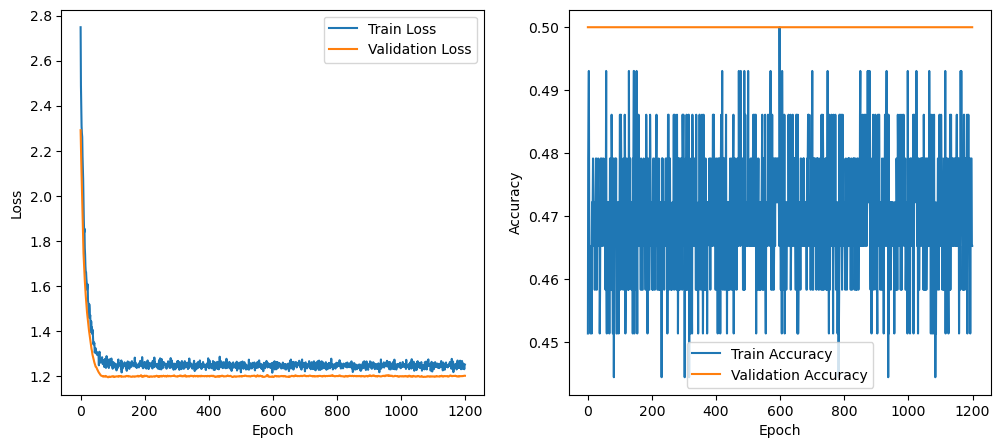

Max Valid Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▄▄▃▃▁▄▁▄▃▁▄▆▆▁█▄▃▆▃▄▆█▃▁▁▄▄▆▄▄▄▄▆▄▃▆▆▆▄▃
Train Loss,█▄▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Max Valid Accuracy,0.5
Train Accuracy,0.46528
Train Loss,1.25155
Validation Accuracy,0.5
Validation Loss,1.2019


In [8]:
threshold = 0.5
age = False
sex = False
method = 'fourier_cluster'
if method == 'coskewness':
    weight = True
else:
    weight = False

hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'
root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
dataset = f.Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

train_loader, valid_loader, test_loader, nbr_classes = f.create_train_test_valid(dataset)

# Defining the model, optimizer and loss function
lr=0.00001
hidden_channels=32
num_layers=3
dropout=0.2
w_decay = 0
parameters = [lr, hidden_channels, num_layers, dropout]
in_channels = dataset.num_features

model = HGConv(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
criterion = torch.nn.CrossEntropyLoss()

# Printing the model architecture
print(model)

# Running the training
train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy = train(model, optimizer, criterion, w_decay, threshold, train_loader, valid_loader, parameters, n_epochs=1200)

In [12]:
# Doing some parameter gridsearch to find the best hyperparameters
from sklearn.model_selection import ParameterGrid

# Building the graphs
threshold = 0.5
age = False
sex = False
method = 'fourier_cluster'
if method == 'coskewness':
    weight = True
else:
    weight = False

hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'
root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
dataset = f.Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes = f.create_train_test_valid(dataset)

# param_grid = {
#     'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
#     'hidden_channels': [128, 64, 32],
#     'num_layers': [3, 2, 1],
#     'dropout_rate': [0.3, 0.2, 0.1, 0.0],
#     'weight_decay': [0.01, 0.001, 0.0001]
# }
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01],
    'hidden_channels': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'weight_decay': [0.0001, 0.001, 0.01]
}

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 800
in_channels = dataset.num_features
# Train using each combination
for params in param_combinations:
    filename = f'HGConv_Models_MP/threshold_{threshold}/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_wdecay{params["weight_decay"]}_w{weight}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
        model = HGConv(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
        criterion = torch.nn.CrossEntropyLoss() 
        if 'weight_decay' not in params.keys():
            w_decay = 0
        else:
            w_decay = params['weight_decay']
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
        train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy = train(model, optimizer, criterion, w_decay, threshold, train_loader, valid_loader, parameters, n_epochs=800)

Number of training graphs: 136
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


wandb: ERROR Control-C detected -- Run data was not synced
